# Test

In [1]:
%load_ext autoreload
%autoreload 2

### Import datasets

Import datasets using functions from src/data/data.py. Datasets are downloaded from huggingface and stored in /data. Once downloaded, datasets are loaded locally.

Run ```pip install -e .``` if module importing isn't working.

In [2]:
import pprint
from src.data.data import get_in_domain, get_out_domain

in_domain_train, in_domain_test = get_in_domain()
out_domain = get_out_domain()

print(f"In domain (MNLI):\n{in_domain_train}")
pprint.pprint(in_domain_train[1])

print(f"\nOut of domain (HANS):\n{out_domain}")
pprint.pprint(out_domain[10])

In domain (MNLI):
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})
{'hypothesis': 'A member of my team will execute your orders with immense '
               'precision.',
 'idx': 2,
 'label': 0,
 'premise': 'One of our number will carry out your instructions minutely.'}

Out of domain (HANS):
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 10000
})
{'binary_parse_hypothesis': '( ( The athlete ) ( ( avoided ( the president ) ) '
                            '. ) )',
 'binary_parse_premise': '( ( The president ) ( ( avoided ( the athlete ) ) . '
                         ') )',
 'heuristic': 'lexical_overlap',
 'hypothesis': 'The athlete avoided the president .',
 'label': 1,
 'parse_hypothesis': '(ROOT (S (NP (DT The) (NN athlete)) (VP (VBD avoided) '
                     '(NP (DT the) (NN president

### Import models

Import models using methods from src/models/opt.py. Models are downloaded from huggingface and stored in /models/pretrained. Once downloaded, models are loaded locally.

In [17]:
from src.model.model import get_model, get_lora_model, print_trainable_parameters

# Get SequenceClassification models
model_opt125, tokenizer_opt125 = get_lora_model(model_name='opt-125m')
model_opt350, tokenizer_opt350 = get_lora_model(model_name='opt-350m')

print_trainable_parameters(model_opt125)
print_trainable_parameters(model_opt350)

trainable params: 167424 || all params: 125389824 || trainable%: 0.13%
cuda:0
trainable params: 443392 || all params: 331591680 || trainable%: 0.13%


### Few-shot finetuning

Perform few-shot fine-tuning using the fine_tune method from /src/finetuners/fewshot.py. This method requires model, tokenizers, and datasets to be passed in as parameters. It returns training and evaluation metrics.

In [15]:
from src.finetuners.fewshot_lora import fine_tune

train_dataset = in_domain_train.select(range(2))
eval_dataset_in = in_domain_test.select(range(2))
eval_dataset_out = out_domain.select(range(2))

combined_metrics, training_history = fine_tune(model=model_opt125, 
                                               tokenizer=tokenizer_opt125, 
                                               train_dataset=train_dataset, 
                                               eval_dataset_in=eval_dataset_in, 
                                               eval_dataset_out=eval_dataset_out, 
                                               val_in_training=False,
                                               verbose=True, 
                                               disable_tqdm=True)

pprint.pprint(combined_metrics)
# print(f"Training history:\n{json.dumps(training_history, indent=4)}")

{'train_runtime': 21.0021, 'train_samples_per_second': 3.809, 'train_steps_per_second': 1.905, 'train_loss': 0.5477104187011719, 'epoch': 40.0, 'train_peak_memory_gb': 3.7036867141723633}
{'eval_in_loss': 0.7475179433822632, 'eval_in_accuracy': 0.0, 'eval_in_runtime': 4.4171, 'eval_in_samples_per_second': 0.453, 'eval_in_steps_per_second': 0.226, 'epoch': 40.0, 'eval_in_peak_memory_gb': 2.6662750244140625}
{'eval_out_loss': 1.181111216545105, 'eval_out_accuracy': 0.0, 'eval_out_runtime': 25.3023, 'eval_out_samples_per_second': 0.079, 'eval_out_steps_per_second': 0.04, 'epoch': 40.0, 'eval_out_peak_memory_gb': 2.6662750244140625}
{'epoch': 40.0,
 'eval_in_accuracy': 0.0,
 'eval_in_loss': 0.7475179433822632,
 'eval_in_peak_memory_gb': 2.6662750244140625,
 'eval_in_runtime': 4.4171,
 'eval_in_samples_per_second': 0.453,
 'eval_in_steps_per_second': 0.226,
 'eval_out_accuracy': 0.0,
 'eval_out_loss': 1.181111216545105,
 'eval_out_peak_memory_gb': 2.6662750244140625,
 'eval_out_runtime': 25

### Batch few-shot finetuning

Perform batch few-shot fine-tuning using batch_fine_tune from /src/finetuners/fewshot.py. This method only requires model_name and training and eval datasets. The selected model is loaded from /models/pretrained for each trial to prevent cumulative fine-tuning. sample_sizes corresponds to the number of shots used for each trial. Each trial is trained and evaluated using data randomly selected by get_random_subsets from /src/utils.py. Results are written to a csv in /logs.

In [22]:
from src.finetuners.fewshot_lora import batch_fine_tune
from src.data.data import get_random_subsets

# Generate training and evaluation datasets. These should be used for all fine-tuning methods to ensure consistency. np.random should be seeded before this.
train_datasets, eval_dataset_in, eval_dataset_out = get_random_subsets(train_dataset=in_domain_train, 
                                                                       eval_dataset_in=in_domain_test, 
                                                                       eval_dataset_out=out_domain, 
                                                                       train_sample_sizes=[2, 4, 6, 8, 16],#[2, 16, 32, 64, 128], # [2, 4],
                                                                       num_trials=10,   # 5
                                                                       eval_sample_size=50) # 10

metrics, training_histories = batch_fine_tune(model_names=['opt-125m', 'opt-350m'], 
                                              train_datasets=train_datasets, 
                                              eval_dataset_in=eval_dataset_in, 
                                              eval_dataset_out=eval_dataset_out, 
                                              exp_label='lora_test', 
                                              save_trials=False)

print("Metrics:")
pprint.pprint(metrics)
print("Training histories:")
pprint.pprint(training_histories)

opt-125m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7027, 'learning_rate': 2.5e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6477312445640564, 'eval_accuracy': 0.6, 'eval_runtime': 14.9793, 'eval_samples_per_second': 0.668, 'eval_steps_per_second': 0.067, 'epoch': 1.0}
{'loss': 0.7276, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6476474404335022, 'eval_accuracy': 0.6, 'eval_runtime': 15.2284, 'eval_samples_per_second': 0.657, 'eval_steps_per_second': 0.066, 'epoch': 2.0}
{'loss': 0.5851, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6474765539169312, 'eval_accuracy': 0.6, 'eval_runtime': 14.716, 'eval_samples_per_second': 0.68, 'eval_steps_per_second': 0.068, 'epoch': 3.0}
{'loss': 0.6055, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6471228003501892, 'eval_accuracy': 0.6, 'eval_runtime': 14.963, 'eval_samples_per_second': 0.668, 'eval_steps_per_second': 0.067, 'epoch': 4.0}
{'loss': 0.6714, 'learning_rate': 9.722222222222223e-06, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6466127634048462, 'eval_accuracy': 0.6, 'eval_runtime': 14.7724, 'eval_samples_per_second': 0.677, 'eval_steps_per_second': 0.068, 'epoch': 5.0}
{'loss': 0.6169, 'learning_rate': 9.444444444444445e-06, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6461018323898315, 'eval_accuracy': 0.6, 'eval_runtime': 14.6962, 'eval_samples_per_second': 0.68, 'eval_steps_per_second': 0.068, 'epoch': 6.0}
{'loss': 0.5158, 'learning_rate': 9.166666666666666e-06, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6455480456352234, 'eval_accuracy': 0.6, 'eval_runtime': 14.7038, 'eval_samples_per_second': 0.68, 'eval_steps_per_second': 0.068, 'epoch': 7.0}
{'loss': 0.6764, 'learning_rate': 8.888888888888888e-06, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6451296806335449, 'eval_accuracy': 0.6, 'eval_runtime': 14.7796, 'eval_samples_per_second': 0.677, 'eval_steps_per_second': 0.068, 'epoch': 8.0}
{'loss': 0.6064, 'learning_rate': 8.611111111111112e-06, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6446970701217651, 'eval_accuracy': 0.6, 'eval_runtime': 14.7905, 'eval_samples_per_second': 0.676, 'eval_steps_per_second': 0.068, 'epoch': 9.0}
{'loss': 0.5388, 'learning_rate': 8.333333333333334e-06, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6442745923995972, 'eval_accuracy': 0.6, 'eval_runtime': 14.6644, 'eval_samples_per_second': 0.682, 'eval_steps_per_second': 0.068, 'epoch': 10.0}
{'loss': 0.7458, 'learning_rate': 8.055555555555557e-06, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6438366174697876, 'eval_accuracy': 0.6, 'eval_runtime': 14.6673, 'eval_samples_per_second': 0.682, 'eval_steps_per_second': 0.068, 'epoch': 11.0}
{'loss': 0.5946, 'learning_rate': 7.77777777777778e-06, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6433802843093872, 'eval_accuracy': 0.6, 'eval_runtime': 14.8121, 'eval_samples_per_second': 0.675, 'eval_steps_per_second': 0.068, 'epoch': 12.0}
{'loss': 0.6504, 'learning_rate': 7.500000000000001e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.643022894859314, 'eval_accuracy': 0.6, 'eval_runtime': 15.1261, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.066, 'epoch': 13.0}
{'loss': 0.5804, 'learning_rate': 7.222222222222223e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6427289843559265, 'eval_accuracy': 0.6, 'eval_runtime': 15.1065, 'eval_samples_per_second': 0.662, 'eval_steps_per_second': 0.066, 'epoch': 14.0}
{'loss': 0.65, 'learning_rate': 6.944444444444445e-06, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6424619555473328, 'eval_accuracy': 0.7, 'eval_runtime': 15.1505, 'eval_samples_per_second': 0.66, 'eval_steps_per_second': 0.066, 'epoch': 15.0}
{'loss': 0.6687, 'learning_rate': 6.666666666666667e-06, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6421907544136047, 'eval_accuracy': 0.7, 'eval_runtime': 15.4627, 'eval_samples_per_second': 0.647, 'eval_steps_per_second': 0.065, 'epoch': 16.0}
{'loss': 0.6278, 'learning_rate': 6.3888888888888885e-06, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419511437416077, 'eval_accuracy': 0.7, 'eval_runtime': 15.0513, 'eval_samples_per_second': 0.664, 'eval_steps_per_second': 0.066, 'epoch': 17.0}
{'loss': 0.561, 'learning_rate': 6.111111111111112e-06, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.641779899597168, 'eval_accuracy': 0.7, 'eval_runtime': 15.0454, 'eval_samples_per_second': 0.665, 'eval_steps_per_second': 0.066, 'epoch': 18.0}
{'loss': 0.6936, 'learning_rate': 5.833333333333334e-06, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6416970491409302, 'eval_accuracy': 0.7, 'eval_runtime': 15.1097, 'eval_samples_per_second': 0.662, 'eval_steps_per_second': 0.066, 'epoch': 19.0}
{'loss': 0.4614, 'learning_rate': 5.555555555555557e-06, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6415835618972778, 'eval_accuracy': 0.7, 'eval_runtime': 15.0496, 'eval_samples_per_second': 0.664, 'eval_steps_per_second': 0.066, 'epoch': 20.0}
{'loss': 0.4991, 'learning_rate': 5.2777777777777785e-06, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6415632963180542, 'eval_accuracy': 0.7, 'eval_runtime': 15.1845, 'eval_samples_per_second': 0.659, 'eval_steps_per_second': 0.066, 'epoch': 21.0}
{'loss': 0.5047, 'learning_rate': 5e-06, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6415778994560242, 'eval_accuracy': 0.7, 'eval_runtime': 15.1817, 'eval_samples_per_second': 0.659, 'eval_steps_per_second': 0.066, 'epoch': 22.0}
{'loss': 0.6059, 'learning_rate': 4.722222222222222e-06, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6416023969650269, 'eval_accuracy': 0.7, 'eval_runtime': 15.1159, 'eval_samples_per_second': 0.662, 'eval_steps_per_second': 0.066, 'epoch': 23.0}
{'loss': 0.7042, 'learning_rate': 4.444444444444444e-06, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6416759490966797, 'eval_accuracy': 0.7, 'eval_runtime': 15.3428, 'eval_samples_per_second': 0.652, 'eval_steps_per_second': 0.065, 'epoch': 24.0}
{'loss': 0.601, 'learning_rate': 4.166666666666667e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6417379379272461, 'eval_accuracy': 0.7, 'eval_runtime': 16.6013, 'eval_samples_per_second': 0.602, 'eval_steps_per_second': 0.06, 'epoch': 25.0}
{'loss': 0.6047, 'learning_rate': 3.88888888888889e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6417974233627319, 'eval_accuracy': 0.7, 'eval_runtime': 17.9254, 'eval_samples_per_second': 0.558, 'eval_steps_per_second': 0.056, 'epoch': 26.0}
{'loss': 0.6334, 'learning_rate': 3.6111111111111115e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6418706178665161, 'eval_accuracy': 0.7, 'eval_runtime': 17.2369, 'eval_samples_per_second': 0.58, 'eval_steps_per_second': 0.058, 'epoch': 27.0}
{'loss': 0.5907, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419126391410828, 'eval_accuracy': 0.7, 'eval_runtime': 15.3015, 'eval_samples_per_second': 0.654, 'eval_steps_per_second': 0.065, 'epoch': 28.0}
{'loss': 0.5742, 'learning_rate': 3.055555555555556e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419821381568909, 'eval_accuracy': 0.7, 'eval_runtime': 15.3551, 'eval_samples_per_second': 0.651, 'eval_steps_per_second': 0.065, 'epoch': 29.0}
{'loss': 0.4417, 'learning_rate': 2.7777777777777783e-06, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6420227289199829, 'eval_accuracy': 0.7, 'eval_runtime': 14.9931, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.067, 'epoch': 30.0}
{'loss': 0.6507, 'learning_rate': 2.5e-06, 'epoch': 31.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6420460939407349, 'eval_accuracy': 0.7, 'eval_runtime': 15.1233, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.066, 'epoch': 31.0}
{'loss': 0.5699, 'learning_rate': 2.222222222222222e-06, 'epoch': 32.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6420407295227051, 'eval_accuracy': 0.7, 'eval_runtime': 15.0891, 'eval_samples_per_second': 0.663, 'eval_steps_per_second': 0.066, 'epoch': 32.0}
{'loss': 0.507, 'learning_rate': 1.944444444444445e-06, 'epoch': 33.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.642034113407135, 'eval_accuracy': 0.7, 'eval_runtime': 15.0191, 'eval_samples_per_second': 0.666, 'eval_steps_per_second': 0.067, 'epoch': 33.0}
{'loss': 0.4784, 'learning_rate': 1.6666666666666667e-06, 'epoch': 34.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6420073509216309, 'eval_accuracy': 0.7, 'eval_runtime': 15.2304, 'eval_samples_per_second': 0.657, 'eval_steps_per_second': 0.066, 'epoch': 34.0}
{'loss': 0.5185, 'learning_rate': 1.3888888888888892e-06, 'epoch': 35.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419671773910522, 'eval_accuracy': 0.7, 'eval_runtime': 15.1305, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.066, 'epoch': 35.0}
{'loss': 0.5821, 'learning_rate': 1.111111111111111e-06, 'epoch': 36.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419402360916138, 'eval_accuracy': 0.7, 'eval_runtime': 15.0375, 'eval_samples_per_second': 0.665, 'eval_steps_per_second': 0.067, 'epoch': 36.0}
{'loss': 0.5348, 'learning_rate': 8.333333333333333e-07, 'epoch': 37.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419225931167603, 'eval_accuracy': 0.7, 'eval_runtime': 15.1483, 'eval_samples_per_second': 0.66, 'eval_steps_per_second': 0.066, 'epoch': 37.0}
{'loss': 0.5235, 'learning_rate': 5.555555555555555e-07, 'epoch': 38.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419099569320679, 'eval_accuracy': 0.7, 'eval_runtime': 15.1768, 'eval_samples_per_second': 0.659, 'eval_steps_per_second': 0.066, 'epoch': 38.0}
{'loss': 0.4954, 'learning_rate': 2.7777777777777776e-07, 'epoch': 39.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6419004201889038, 'eval_accuracy': 0.7, 'eval_runtime': 15.1398, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.066, 'epoch': 39.0}
{'loss': 0.5833, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6418983340263367, 'eval_accuracy': 0.7, 'eval_runtime': 14.986, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.067, 'epoch': 40.0}
{'train_runtime': 723.3853, 'train_samples_per_second': 0.111, 'train_steps_per_second': 0.055, 'train_loss': 0.5920889876782894, 'epoch': 40.0, 'train_peak_memory_gb': 4.65462589263916}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6629, 'learning_rate': 2.5e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6946821212768555, 'eval_accuracy': 0.4, 'eval_runtime': 9.5385, 'eval_samples_per_second': 1.048, 'eval_steps_per_second': 0.105, 'epoch': 1.0}
{'loss': 0.5989, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6940721273422241, 'eval_accuracy': 0.4, 'eval_runtime': 8.9943, 'eval_samples_per_second': 1.112, 'eval_steps_per_second': 0.111, 'epoch': 2.0}
{'loss': 0.4874, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6928739547729492, 'eval_accuracy': 0.4, 'eval_runtime': 9.0974, 'eval_samples_per_second': 1.099, 'eval_steps_per_second': 0.11, 'epoch': 3.0}
{'loss': 0.5658, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6911183595657349, 'eval_accuracy': 0.4, 'eval_runtime': 18.9496, 'eval_samples_per_second': 0.528, 'eval_steps_per_second': 0.053, 'epoch': 4.0}
{'loss': 0.5878, 'learning_rate': 9.722222222222223e-06, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6888831853866577, 'eval_accuracy': 0.4, 'eval_runtime': 9.0745, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.11, 'epoch': 5.0}
{'loss': 0.7139, 'learning_rate': 9.444444444444445e-06, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.686813235282898, 'eval_accuracy': 0.3, 'eval_runtime': 8.9474, 'eval_samples_per_second': 1.118, 'eval_steps_per_second': 0.112, 'epoch': 6.0}
{'loss': 0.615, 'learning_rate': 9.166666666666666e-06, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6848927736282349, 'eval_accuracy': 0.3, 'eval_runtime': 8.9538, 'eval_samples_per_second': 1.117, 'eval_steps_per_second': 0.112, 'epoch': 7.0}
{'loss': 0.5866, 'learning_rate': 8.888888888888888e-06, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6830998659133911, 'eval_accuracy': 0.3, 'eval_runtime': 9.085, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.11, 'epoch': 8.0}
{'loss': 0.6482, 'learning_rate': 8.611111111111112e-06, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6813970804214478, 'eval_accuracy': 0.3, 'eval_runtime': 9.091, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.11, 'epoch': 9.0}
{'loss': 0.613, 'learning_rate': 8.333333333333334e-06, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6798118352890015, 'eval_accuracy': 0.3, 'eval_runtime': 9.0194, 'eval_samples_per_second': 1.109, 'eval_steps_per_second': 0.111, 'epoch': 10.0}
{'loss': 0.4879, 'learning_rate': 8.055555555555557e-06, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6783512830734253, 'eval_accuracy': 0.5, 'eval_runtime': 8.9786, 'eval_samples_per_second': 1.114, 'eval_steps_per_second': 0.111, 'epoch': 11.0}
{'loss': 0.4708, 'learning_rate': 7.77777777777778e-06, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6769989728927612, 'eval_accuracy': 0.5, 'eval_runtime': 9.1294, 'eval_samples_per_second': 1.095, 'eval_steps_per_second': 0.11, 'epoch': 12.0}
{'loss': 0.5229, 'learning_rate': 7.500000000000001e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6757539510726929, 'eval_accuracy': 0.5, 'eval_runtime': 9.0334, 'eval_samples_per_second': 1.107, 'eval_steps_per_second': 0.111, 'epoch': 13.0}
{'loss': 0.4518, 'learning_rate': 7.222222222222223e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6746140718460083, 'eval_accuracy': 0.5, 'eval_runtime': 9.1368, 'eval_samples_per_second': 1.094, 'eval_steps_per_second': 0.109, 'epoch': 14.0}
{'loss': 0.4621, 'learning_rate': 6.944444444444445e-06, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.673568606376648, 'eval_accuracy': 0.5, 'eval_runtime': 9.1183, 'eval_samples_per_second': 1.097, 'eval_steps_per_second': 0.11, 'epoch': 15.0}
{'loss': 0.484, 'learning_rate': 6.666666666666667e-06, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6726008653640747, 'eval_accuracy': 0.5, 'eval_runtime': 9.0727, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.11, 'epoch': 16.0}
{'loss': 0.4499, 'learning_rate': 6.3888888888888885e-06, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6716951131820679, 'eval_accuracy': 0.5, 'eval_runtime': 9.17, 'eval_samples_per_second': 1.091, 'eval_steps_per_second': 0.109, 'epoch': 17.0}
{'loss': 0.4978, 'learning_rate': 6.111111111111112e-06, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6708720922470093, 'eval_accuracy': 0.5, 'eval_runtime': 9.1928, 'eval_samples_per_second': 1.088, 'eval_steps_per_second': 0.109, 'epoch': 18.0}
{'loss': 0.3929, 'learning_rate': 5.833333333333334e-06, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6701241135597229, 'eval_accuracy': 0.6, 'eval_runtime': 8.9727, 'eval_samples_per_second': 1.114, 'eval_steps_per_second': 0.111, 'epoch': 19.0}
{'loss': 0.4815, 'learning_rate': 5.555555555555557e-06, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6694322824478149, 'eval_accuracy': 0.6, 'eval_runtime': 9.1477, 'eval_samples_per_second': 1.093, 'eval_steps_per_second': 0.109, 'epoch': 20.0}
{'loss': 0.4289, 'learning_rate': 5.2777777777777785e-06, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6688026189804077, 'eval_accuracy': 0.6, 'eval_runtime': 8.9616, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.112, 'epoch': 21.0}
{'loss': 0.388, 'learning_rate': 5e-06, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.668237566947937, 'eval_accuracy': 0.6, 'eval_runtime': 8.9976, 'eval_samples_per_second': 1.111, 'eval_steps_per_second': 0.111, 'epoch': 22.0}
{'loss': 0.4033, 'learning_rate': 4.722222222222222e-06, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.667728066444397, 'eval_accuracy': 0.6, 'eval_runtime': 9.094, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.11, 'epoch': 23.0}
{'loss': 0.3833, 'learning_rate': 4.444444444444444e-06, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.667264461517334, 'eval_accuracy': 0.6, 'eval_runtime': 9.0738, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.11, 'epoch': 24.0}
{'loss': 0.3994, 'learning_rate': 4.166666666666667e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.666833758354187, 'eval_accuracy': 0.6, 'eval_runtime': 9.0646, 'eval_samples_per_second': 1.103, 'eval_steps_per_second': 0.11, 'epoch': 25.0}
{'loss': 0.4025, 'learning_rate': 3.88888888888889e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6664376258850098, 'eval_accuracy': 0.6, 'eval_runtime': 9.0505, 'eval_samples_per_second': 1.105, 'eval_steps_per_second': 0.11, 'epoch': 26.0}
{'loss': 0.5292, 'learning_rate': 3.6111111111111115e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6660810708999634, 'eval_accuracy': 0.6, 'eval_runtime': 9.0937, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.11, 'epoch': 27.0}
{'loss': 0.4377, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6657611727714539, 'eval_accuracy': 0.6, 'eval_runtime': 9.0278, 'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.111, 'epoch': 28.0}
{'loss': 0.4092, 'learning_rate': 3.055555555555556e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6654781103134155, 'eval_accuracy': 0.6, 'eval_runtime': 9.1042, 'eval_samples_per_second': 1.098, 'eval_steps_per_second': 0.11, 'epoch': 29.0}
{'loss': 0.4008, 'learning_rate': 2.7777777777777783e-06, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6652239561080933, 'eval_accuracy': 0.6, 'eval_runtime': 9.153, 'eval_samples_per_second': 1.093, 'eval_steps_per_second': 0.109, 'epoch': 30.0}
{'loss': 0.3349, 'learning_rate': 2.5e-06, 'epoch': 31.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6650005578994751, 'eval_accuracy': 0.6, 'eval_runtime': 9.1051, 'eval_samples_per_second': 1.098, 'eval_steps_per_second': 0.11, 'epoch': 31.0}
{'loss': 0.3215, 'learning_rate': 2.222222222222222e-06, 'epoch': 32.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6648050546646118, 'eval_accuracy': 0.6, 'eval_runtime': 9.1791, 'eval_samples_per_second': 1.089, 'eval_steps_per_second': 0.109, 'epoch': 32.0}
{'loss': 0.3374, 'learning_rate': 1.944444444444445e-06, 'epoch': 33.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6646360158920288, 'eval_accuracy': 0.6, 'eval_runtime': 9.3071, 'eval_samples_per_second': 1.074, 'eval_steps_per_second': 0.107, 'epoch': 33.0}
{'loss': 0.4133, 'learning_rate': 1.6666666666666667e-06, 'epoch': 34.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.664490282535553, 'eval_accuracy': 0.6, 'eval_runtime': 9.0558, 'eval_samples_per_second': 1.104, 'eval_steps_per_second': 0.11, 'epoch': 34.0}
{'loss': 0.3449, 'learning_rate': 1.3888888888888892e-06, 'epoch': 35.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.664367139339447, 'eval_accuracy': 0.6, 'eval_runtime': 11.3793, 'eval_samples_per_second': 0.879, 'eval_steps_per_second': 0.088, 'epoch': 35.0}
{'loss': 0.3957, 'learning_rate': 1.111111111111111e-06, 'epoch': 36.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6642665266990662, 'eval_accuracy': 0.6, 'eval_runtime': 9.7361, 'eval_samples_per_second': 1.027, 'eval_steps_per_second': 0.103, 'epoch': 36.0}
{'loss': 0.4429, 'learning_rate': 8.333333333333333e-07, 'epoch': 37.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6641887426376343, 'eval_accuracy': 0.6, 'eval_runtime': 9.3227, 'eval_samples_per_second': 1.073, 'eval_steps_per_second': 0.107, 'epoch': 37.0}
{'loss': 0.3647, 'learning_rate': 5.555555555555555e-07, 'epoch': 38.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6641309857368469, 'eval_accuracy': 0.6, 'eval_runtime': 9.0188, 'eval_samples_per_second': 1.109, 'eval_steps_per_second': 0.111, 'epoch': 38.0}
{'loss': 0.3319, 'learning_rate': 2.7777777777777776e-07, 'epoch': 39.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6640929579734802, 'eval_accuracy': 0.6, 'eval_runtime': 9.151, 'eval_samples_per_second': 1.093, 'eval_steps_per_second': 0.109, 'epoch': 39.0}
{'loss': 0.3382, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6640740633010864, 'eval_accuracy': 0.6, 'eval_runtime': 9.0735, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.11, 'epoch': 40.0}
{'train_runtime': 507.5244, 'train_samples_per_second': 0.158, 'train_steps_per_second': 0.079, 'train_loss': 0.4647229090332985, 'epoch': 40.0, 'train_peak_memory_gb': 4.636595726013184}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7616, 'learning_rate': 2.5e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6946821212768555, 'eval_accuracy': 0.4, 'eval_runtime': 11.182, 'eval_samples_per_second': 0.894, 'eval_steps_per_second': 0.089, 'epoch': 1.0}
{'loss': 0.7083, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6952842473983765, 'eval_accuracy': 0.4, 'eval_runtime': 11.1775, 'eval_samples_per_second': 0.895, 'eval_steps_per_second': 0.089, 'epoch': 2.0}
{'loss': 0.6556, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6965152025222778, 'eval_accuracy': 0.5, 'eval_runtime': 11.069, 'eval_samples_per_second': 0.903, 'eval_steps_per_second': 0.09, 'epoch': 3.0}
{'loss': 0.7636, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6984082460403442, 'eval_accuracy': 0.5, 'eval_runtime': 11.1341, 'eval_samples_per_second': 0.898, 'eval_steps_per_second': 0.09, 'epoch': 4.0}
{'loss': 0.728, 'learning_rate': 9.722222222222223e-06, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7009517550468445, 'eval_accuracy': 0.6, 'eval_runtime': 11.2305, 'eval_samples_per_second': 0.89, 'eval_steps_per_second': 0.089, 'epoch': 5.0}
{'loss': 0.6972, 'learning_rate': 9.444444444444445e-06, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7035265564918518, 'eval_accuracy': 0.6, 'eval_runtime': 11.2514, 'eval_samples_per_second': 0.889, 'eval_steps_per_second': 0.089, 'epoch': 6.0}
{'loss': 0.7317, 'learning_rate': 9.166666666666666e-06, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7061032056808472, 'eval_accuracy': 0.6, 'eval_runtime': 11.1915, 'eval_samples_per_second': 0.894, 'eval_steps_per_second': 0.089, 'epoch': 7.0}
{'loss': 0.6517, 'learning_rate': 8.888888888888888e-06, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7086783647537231, 'eval_accuracy': 0.6, 'eval_runtime': 11.0785, 'eval_samples_per_second': 0.903, 'eval_steps_per_second': 0.09, 'epoch': 8.0}
{'loss': 0.5398, 'learning_rate': 8.611111111111112e-06, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7112804651260376, 'eval_accuracy': 0.6, 'eval_runtime': 11.127, 'eval_samples_per_second': 0.899, 'eval_steps_per_second': 0.09, 'epoch': 9.0}
{'loss': 0.6069, 'learning_rate': 8.333333333333334e-06, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7138913869857788, 'eval_accuracy': 0.5, 'eval_runtime': 11.0539, 'eval_samples_per_second': 0.905, 'eval_steps_per_second': 0.09, 'epoch': 10.0}
{'loss': 0.5963, 'learning_rate': 8.055555555555557e-06, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7165144681930542, 'eval_accuracy': 0.5, 'eval_runtime': 11.1097, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 11.0}
{'loss': 0.5522, 'learning_rate': 7.77777777777778e-06, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.719140887260437, 'eval_accuracy': 0.5, 'eval_runtime': 11.187, 'eval_samples_per_second': 0.894, 'eval_steps_per_second': 0.089, 'epoch': 12.0}
{'loss': 0.6135, 'learning_rate': 7.500000000000001e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7217221260070801, 'eval_accuracy': 0.5, 'eval_runtime': 11.0621, 'eval_samples_per_second': 0.904, 'eval_steps_per_second': 0.09, 'epoch': 13.0}
{'loss': 0.5749, 'learning_rate': 7.222222222222223e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7242555022239685, 'eval_accuracy': 0.5, 'eval_runtime': 11.0442, 'eval_samples_per_second': 0.905, 'eval_steps_per_second': 0.091, 'epoch': 14.0}
{'loss': 0.5463, 'learning_rate': 6.944444444444445e-06, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7267142534255981, 'eval_accuracy': 0.5, 'eval_runtime': 11.2234, 'eval_samples_per_second': 0.891, 'eval_steps_per_second': 0.089, 'epoch': 15.0}
{'loss': 0.5112, 'learning_rate': 6.666666666666667e-06, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7291455864906311, 'eval_accuracy': 0.5, 'eval_runtime': 11.2413, 'eval_samples_per_second': 0.89, 'eval_steps_per_second': 0.089, 'epoch': 16.0}
{'loss': 0.5852, 'learning_rate': 6.3888888888888885e-06, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7315559983253479, 'eval_accuracy': 0.5, 'eval_runtime': 11.2934, 'eval_samples_per_second': 0.885, 'eval_steps_per_second': 0.089, 'epoch': 17.0}
{'loss': 0.5105, 'learning_rate': 6.111111111111112e-06, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7339314222335815, 'eval_accuracy': 0.5, 'eval_runtime': 11.1117, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 18.0}
{'loss': 0.4937, 'learning_rate': 5.833333333333334e-06, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7362308502197266, 'eval_accuracy': 0.5, 'eval_runtime': 11.1817, 'eval_samples_per_second': 0.894, 'eval_steps_per_second': 0.089, 'epoch': 19.0}
{'loss': 0.4969, 'learning_rate': 5.555555555555557e-06, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7384609580039978, 'eval_accuracy': 0.5, 'eval_runtime': 11.1512, 'eval_samples_per_second': 0.897, 'eval_steps_per_second': 0.09, 'epoch': 20.0}
{'loss': 0.5431, 'learning_rate': 5.2777777777777785e-06, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7406197786331177, 'eval_accuracy': 0.5, 'eval_runtime': 11.1095, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 21.0}
{'loss': 0.4621, 'learning_rate': 5e-06, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7426767349243164, 'eval_accuracy': 0.5, 'eval_runtime': 11.1247, 'eval_samples_per_second': 0.899, 'eval_steps_per_second': 0.09, 'epoch': 22.0}
{'loss': 0.588, 'learning_rate': 4.722222222222222e-06, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7446540594100952, 'eval_accuracy': 0.5, 'eval_runtime': 11.1034, 'eval_samples_per_second': 0.901, 'eval_steps_per_second': 0.09, 'epoch': 23.0}
{'loss': 0.4038, 'learning_rate': 4.444444444444444e-06, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7465513944625854, 'eval_accuracy': 0.5, 'eval_runtime': 11.0751, 'eval_samples_per_second': 0.903, 'eval_steps_per_second': 0.09, 'epoch': 24.0}
{'loss': 0.4468, 'learning_rate': 4.166666666666667e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.748369038105011, 'eval_accuracy': 0.5, 'eval_runtime': 11.0879, 'eval_samples_per_second': 0.902, 'eval_steps_per_second': 0.09, 'epoch': 25.0}
{'loss': 0.5836, 'learning_rate': 3.88888888888889e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7500559091567993, 'eval_accuracy': 0.5, 'eval_runtime': 11.1498, 'eval_samples_per_second': 0.897, 'eval_steps_per_second': 0.09, 'epoch': 26.0}
{'loss': 0.4679, 'learning_rate': 3.6111111111111115e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7516313791275024, 'eval_accuracy': 0.5, 'eval_runtime': 11.0219, 'eval_samples_per_second': 0.907, 'eval_steps_per_second': 0.091, 'epoch': 27.0}
{'loss': 0.5032, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7531057596206665, 'eval_accuracy': 0.5, 'eval_runtime': 11.1149, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 28.0}
{'loss': 0.4355, 'learning_rate': 3.055555555555556e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7544833421707153, 'eval_accuracy': 0.5, 'eval_runtime': 11.047, 'eval_samples_per_second': 0.905, 'eval_steps_per_second': 0.091, 'epoch': 29.0}
{'loss': 0.4412, 'learning_rate': 2.7777777777777783e-06, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7557473182678223, 'eval_accuracy': 0.5, 'eval_runtime': 11.0619, 'eval_samples_per_second': 0.904, 'eval_steps_per_second': 0.09, 'epoch': 30.0}
{'loss': 0.3955, 'learning_rate': 2.5e-06, 'epoch': 31.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7568990588188171, 'eval_accuracy': 0.5, 'eval_runtime': 11.4211, 'eval_samples_per_second': 0.876, 'eval_steps_per_second': 0.088, 'epoch': 31.0}
{'loss': 0.3357, 'learning_rate': 2.222222222222222e-06, 'epoch': 32.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7579470276832581, 'eval_accuracy': 0.5, 'eval_runtime': 11.1086, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 32.0}
{'loss': 0.4442, 'learning_rate': 1.944444444444445e-06, 'epoch': 33.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7588847875595093, 'eval_accuracy': 0.5, 'eval_runtime': 11.2021, 'eval_samples_per_second': 0.893, 'eval_steps_per_second': 0.089, 'epoch': 33.0}
{'loss': 0.5182, 'learning_rate': 1.6666666666666667e-06, 'epoch': 34.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7596997022628784, 'eval_accuracy': 0.5, 'eval_runtime': 11.0604, 'eval_samples_per_second': 0.904, 'eval_steps_per_second': 0.09, 'epoch': 34.0}
{'loss': 0.357, 'learning_rate': 1.3888888888888892e-06, 'epoch': 35.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7604070901870728, 'eval_accuracy': 0.5, 'eval_runtime': 11.0797, 'eval_samples_per_second': 0.903, 'eval_steps_per_second': 0.09, 'epoch': 35.0}
{'loss': 0.3847, 'learning_rate': 1.111111111111111e-06, 'epoch': 36.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7609940767288208, 'eval_accuracy': 0.5, 'eval_runtime': 11.1636, 'eval_samples_per_second': 0.896, 'eval_steps_per_second': 0.09, 'epoch': 36.0}
{'loss': 0.3972, 'learning_rate': 8.333333333333333e-07, 'epoch': 37.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7614645957946777, 'eval_accuracy': 0.5, 'eval_runtime': 11.1659, 'eval_samples_per_second': 0.896, 'eval_steps_per_second': 0.09, 'epoch': 37.0}
{'loss': 0.4552, 'learning_rate': 5.555555555555555e-07, 'epoch': 38.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7618169188499451, 'eval_accuracy': 0.5, 'eval_runtime': 11.1296, 'eval_samples_per_second': 0.899, 'eval_steps_per_second': 0.09, 'epoch': 38.0}
{'loss': 0.4271, 'learning_rate': 2.7777777777777776e-07, 'epoch': 39.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7620523571968079, 'eval_accuracy': 0.5, 'eval_runtime': 13.0263, 'eval_samples_per_second': 0.768, 'eval_steps_per_second': 0.077, 'epoch': 39.0}
{'loss': 0.4073, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7621711492538452, 'eval_accuracy': 0.5, 'eval_runtime': 11.2501, 'eval_samples_per_second': 0.889, 'eval_steps_per_second': 0.089, 'epoch': 40.0}
{'train_runtime': 501.8864, 'train_samples_per_second': 0.159, 'train_steps_per_second': 0.08, 'train_loss': 0.5330687291920185, 'epoch': 40.0, 'train_peak_memory_gb': 4.63710880279541}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.0855, 'learning_rate': 2.5e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6946821212768555, 'eval_accuracy': 0.4, 'eval_runtime': 9.3377, 'eval_samples_per_second': 1.071, 'eval_steps_per_second': 0.107, 'epoch': 1.0}
{'loss': 1.0264, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.695226788520813, 'eval_accuracy': 0.4, 'eval_runtime': 9.1601, 'eval_samples_per_second': 1.092, 'eval_steps_per_second': 0.109, 'epoch': 2.0}
{'loss': 0.9204, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6963487863540649, 'eval_accuracy': 0.5, 'eval_runtime': 9.1224, 'eval_samples_per_second': 1.096, 'eval_steps_per_second': 0.11, 'epoch': 3.0}
{'loss': 0.9773, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6980518102645874, 'eval_accuracy': 0.5, 'eval_runtime': 9.2888, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.108, 'epoch': 4.0}
{'loss': 0.8925, 'learning_rate': 9.722222222222223e-06, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.700334906578064, 'eval_accuracy': 0.6, 'eval_runtime': 10.0357, 'eval_samples_per_second': 0.996, 'eval_steps_per_second': 0.1, 'epoch': 5.0}
{'loss': 0.9135, 'learning_rate': 9.444444444444445e-06, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.702632486820221, 'eval_accuracy': 0.6, 'eval_runtime': 9.4492, 'eval_samples_per_second': 1.058, 'eval_steps_per_second': 0.106, 'epoch': 6.0}
{'loss': 0.853, 'learning_rate': 9.166666666666666e-06, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7049217820167542, 'eval_accuracy': 0.6, 'eval_runtime': 9.1747, 'eval_samples_per_second': 1.09, 'eval_steps_per_second': 0.109, 'epoch': 7.0}
{'loss': 0.8008, 'learning_rate': 8.888888888888888e-06, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7071617841720581, 'eval_accuracy': 0.6, 'eval_runtime': 9.1769, 'eval_samples_per_second': 1.09, 'eval_steps_per_second': 0.109, 'epoch': 8.0}
{'loss': 0.8176, 'learning_rate': 8.611111111111112e-06, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7093449831008911, 'eval_accuracy': 0.6, 'eval_runtime': 9.2969, 'eval_samples_per_second': 1.076, 'eval_steps_per_second': 0.108, 'epoch': 9.0}
{'loss': 0.856, 'learning_rate': 8.333333333333334e-06, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.711542546749115, 'eval_accuracy': 0.6, 'eval_runtime': 9.203, 'eval_samples_per_second': 1.087, 'eval_steps_per_second': 0.109, 'epoch': 10.0}
{'loss': 0.8723, 'learning_rate': 8.055555555555557e-06, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7137404680252075, 'eval_accuracy': 0.6, 'eval_runtime': 9.2276, 'eval_samples_per_second': 1.084, 'eval_steps_per_second': 0.108, 'epoch': 11.0}
{'loss': 0.984, 'learning_rate': 7.77777777777778e-06, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7159334421157837, 'eval_accuracy': 0.6, 'eval_runtime': 9.2022, 'eval_samples_per_second': 1.087, 'eval_steps_per_second': 0.109, 'epoch': 12.0}
{'loss': 0.7533, 'learning_rate': 7.500000000000001e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7180637121200562, 'eval_accuracy': 0.5, 'eval_runtime': 9.2216, 'eval_samples_per_second': 1.084, 'eval_steps_per_second': 0.108, 'epoch': 13.0}
{'loss': 0.996, 'learning_rate': 7.222222222222223e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7201939821243286, 'eval_accuracy': 0.5, 'eval_runtime': 9.3569, 'eval_samples_per_second': 1.069, 'eval_steps_per_second': 0.107, 'epoch': 14.0}
{'loss': 0.8101, 'learning_rate': 6.944444444444445e-06, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7223005294799805, 'eval_accuracy': 0.5, 'eval_runtime': 10.4209, 'eval_samples_per_second': 0.96, 'eval_steps_per_second': 0.096, 'epoch': 15.0}
{'loss': 0.8646, 'learning_rate': 6.666666666666667e-06, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7243719100952148, 'eval_accuracy': 0.5, 'eval_runtime': 9.6107, 'eval_samples_per_second': 1.041, 'eval_steps_per_second': 0.104, 'epoch': 16.0}
{'loss': 0.8929, 'learning_rate': 6.3888888888888885e-06, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7264186143875122, 'eval_accuracy': 0.5, 'eval_runtime': 9.5239, 'eval_samples_per_second': 1.05, 'eval_steps_per_second': 0.105, 'epoch': 17.0}
{'loss': 0.725, 'learning_rate': 6.111111111111112e-06, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7284391522407532, 'eval_accuracy': 0.5, 'eval_runtime': 9.27, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.108, 'epoch': 18.0}
{'loss': 0.8156, 'learning_rate': 5.833333333333334e-06, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7304030656814575, 'eval_accuracy': 0.5, 'eval_runtime': 9.5396, 'eval_samples_per_second': 1.048, 'eval_steps_per_second': 0.105, 'epoch': 19.0}
{'loss': 0.9601, 'learning_rate': 5.555555555555557e-06, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7322975397109985, 'eval_accuracy': 0.5, 'eval_runtime': 9.5417, 'eval_samples_per_second': 1.048, 'eval_steps_per_second': 0.105, 'epoch': 20.0}
{'loss': 0.6917, 'learning_rate': 5.2777777777777785e-06, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7341400384902954, 'eval_accuracy': 0.5, 'eval_runtime': 9.6861, 'eval_samples_per_second': 1.032, 'eval_steps_per_second': 0.103, 'epoch': 21.0}
{'loss': 0.687, 'learning_rate': 5e-06, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7359153032302856, 'eval_accuracy': 0.5, 'eval_runtime': 9.5031, 'eval_samples_per_second': 1.052, 'eval_steps_per_second': 0.105, 'epoch': 22.0}
{'loss': 0.6598, 'learning_rate': 4.722222222222222e-06, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7376168966293335, 'eval_accuracy': 0.5, 'eval_runtime': 9.3198, 'eval_samples_per_second': 1.073, 'eval_steps_per_second': 0.107, 'epoch': 23.0}
{'loss': 0.5923, 'learning_rate': 4.444444444444444e-06, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7392536401748657, 'eval_accuracy': 0.5, 'eval_runtime': 11.8505, 'eval_samples_per_second': 0.844, 'eval_steps_per_second': 0.084, 'epoch': 24.0}
{'loss': 0.6259, 'learning_rate': 4.166666666666667e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7407912015914917, 'eval_accuracy': 0.5, 'eval_runtime': 9.9649, 'eval_samples_per_second': 1.004, 'eval_steps_per_second': 0.1, 'epoch': 25.0}
{'loss': 0.7664, 'learning_rate': 3.88888888888889e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7422384023666382, 'eval_accuracy': 0.5, 'eval_runtime': 9.7057, 'eval_samples_per_second': 1.03, 'eval_steps_per_second': 0.103, 'epoch': 26.0}
{'loss': 0.5626, 'learning_rate': 3.6111111111111115e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.743606686592102, 'eval_accuracy': 0.5, 'eval_runtime': 9.4826, 'eval_samples_per_second': 1.055, 'eval_steps_per_second': 0.105, 'epoch': 27.0}
{'loss': 0.5778, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7448874711990356, 'eval_accuracy': 0.5, 'eval_runtime': 9.2705, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.108, 'epoch': 28.0}
{'loss': 0.6481, 'learning_rate': 3.055555555555556e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7460721731185913, 'eval_accuracy': 0.5, 'eval_runtime': 9.2804, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.108, 'epoch': 29.0}
{'loss': 0.7617, 'learning_rate': 2.7777777777777783e-06, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7471598982810974, 'eval_accuracy': 0.5, 'eval_runtime': 9.2865, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.108, 'epoch': 30.0}
{'loss': 0.6955, 'learning_rate': 2.5e-06, 'epoch': 31.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7481557130813599, 'eval_accuracy': 0.5, 'eval_runtime': 9.1968, 'eval_samples_per_second': 1.087, 'eval_steps_per_second': 0.109, 'epoch': 31.0}
{'loss': 0.5623, 'learning_rate': 2.222222222222222e-06, 'epoch': 32.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7490614652633667, 'eval_accuracy': 0.5, 'eval_runtime': 9.5125, 'eval_samples_per_second': 1.051, 'eval_steps_per_second': 0.105, 'epoch': 32.0}
{'loss': 0.7553, 'learning_rate': 1.944444444444445e-06, 'epoch': 33.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7498780488967896, 'eval_accuracy': 0.5, 'eval_runtime': 9.1997, 'eval_samples_per_second': 1.087, 'eval_steps_per_second': 0.109, 'epoch': 33.0}
{'loss': 0.6389, 'learning_rate': 1.6666666666666667e-06, 'epoch': 34.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.750585675239563, 'eval_accuracy': 0.5, 'eval_runtime': 9.4156, 'eval_samples_per_second': 1.062, 'eval_steps_per_second': 0.106, 'epoch': 34.0}
{'loss': 0.602, 'learning_rate': 1.3888888888888892e-06, 'epoch': 35.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7512027025222778, 'eval_accuracy': 0.5, 'eval_runtime': 9.181, 'eval_samples_per_second': 1.089, 'eval_steps_per_second': 0.109, 'epoch': 35.0}
{'loss': 0.7966, 'learning_rate': 1.111111111111111e-06, 'epoch': 36.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7517138123512268, 'eval_accuracy': 0.5, 'eval_runtime': 9.326, 'eval_samples_per_second': 1.072, 'eval_steps_per_second': 0.107, 'epoch': 36.0}
{'loss': 0.6594, 'learning_rate': 8.333333333333333e-07, 'epoch': 37.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7521246671676636, 'eval_accuracy': 0.5, 'eval_runtime': 9.3908, 'eval_samples_per_second': 1.065, 'eval_steps_per_second': 0.106, 'epoch': 37.0}
{'loss': 0.6572, 'learning_rate': 5.555555555555555e-07, 'epoch': 38.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7524320483207703, 'eval_accuracy': 0.5, 'eval_runtime': 9.5418, 'eval_samples_per_second': 1.048, 'eval_steps_per_second': 0.105, 'epoch': 38.0}
{'loss': 0.6242, 'learning_rate': 2.7777777777777776e-07, 'epoch': 39.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7526344060897827, 'eval_accuracy': 0.5, 'eval_runtime': 9.4186, 'eval_samples_per_second': 1.062, 'eval_steps_per_second': 0.106, 'epoch': 39.0}
{'loss': 0.6185, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7527381181716919, 'eval_accuracy': 0.5, 'eval_runtime': 9.336, 'eval_samples_per_second': 1.071, 'eval_steps_per_second': 0.107, 'epoch': 40.0}
{'train_runtime': 516.1436, 'train_samples_per_second': 0.155, 'train_steps_per_second': 0.077, 'train_loss': 0.7750082343816758, 'epoch': 40.0, 'train_peak_memory_gb': 4.636595726013184}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.3896, 'learning_rate': 2.5e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6946821212768555, 'eval_accuracy': 0.4, 'eval_runtime': 11.3051, 'eval_samples_per_second': 0.885, 'eval_steps_per_second': 0.088, 'epoch': 1.0}
{'loss': 0.4835, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6946759819984436, 'eval_accuracy': 0.4, 'eval_runtime': 11.2963, 'eval_samples_per_second': 0.885, 'eval_steps_per_second': 0.089, 'epoch': 2.0}
{'loss': 0.3769, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6948803067207336, 'eval_accuracy': 0.4, 'eval_runtime': 11.5683, 'eval_samples_per_second': 0.864, 'eval_steps_per_second': 0.086, 'epoch': 3.0}
{'loss': 0.3942, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6954748034477234, 'eval_accuracy': 0.4, 'eval_runtime': 11.4229, 'eval_samples_per_second': 0.875, 'eval_steps_per_second': 0.088, 'epoch': 4.0}
{'loss': 0.3843, 'learning_rate': 9.722222222222223e-06, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6962279081344604, 'eval_accuracy': 0.5, 'eval_runtime': 12.2304, 'eval_samples_per_second': 0.818, 'eval_steps_per_second': 0.082, 'epoch': 5.0}
{'loss': 0.4097, 'learning_rate': 9.444444444444445e-06, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6969836950302124, 'eval_accuracy': 0.5, 'eval_runtime': 12.0598, 'eval_samples_per_second': 0.829, 'eval_steps_per_second': 0.083, 'epoch': 6.0}
{'loss': 0.3924, 'learning_rate': 9.166666666666666e-06, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6977475881576538, 'eval_accuracy': 0.5, 'eval_runtime': 12.4804, 'eval_samples_per_second': 0.801, 'eval_steps_per_second': 0.08, 'epoch': 7.0}
{'loss': 0.421, 'learning_rate': 8.888888888888888e-06, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6985068321228027, 'eval_accuracy': 0.5, 'eval_runtime': 12.1884, 'eval_samples_per_second': 0.82, 'eval_steps_per_second': 0.082, 'epoch': 8.0}
{'loss': 0.416, 'learning_rate': 8.611111111111112e-06, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6992777585983276, 'eval_accuracy': 0.5, 'eval_runtime': 12.2242, 'eval_samples_per_second': 0.818, 'eval_steps_per_second': 0.082, 'epoch': 9.0}
{'loss': 0.4299, 'learning_rate': 8.333333333333334e-06, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6998740434646606, 'eval_accuracy': 0.5, 'eval_runtime': 11.3269, 'eval_samples_per_second': 0.883, 'eval_steps_per_second': 0.088, 'epoch': 10.0}
{'loss': 0.4828, 'learning_rate': 8.055555555555557e-06, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7003735899925232, 'eval_accuracy': 0.5, 'eval_runtime': 11.261, 'eval_samples_per_second': 0.888, 'eval_steps_per_second': 0.089, 'epoch': 11.0}
{'loss': 0.3748, 'learning_rate': 7.77777777777778e-06, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7008124589920044, 'eval_accuracy': 0.5, 'eval_runtime': 11.2996, 'eval_samples_per_second': 0.885, 'eval_steps_per_second': 0.088, 'epoch': 12.0}
{'loss': 0.5497, 'learning_rate': 7.500000000000001e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7011866569519043, 'eval_accuracy': 0.6, 'eval_runtime': 11.2467, 'eval_samples_per_second': 0.889, 'eval_steps_per_second': 0.089, 'epoch': 13.0}
{'loss': 0.6458, 'learning_rate': 7.222222222222223e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7013791799545288, 'eval_accuracy': 0.6, 'eval_runtime': 11.3065, 'eval_samples_per_second': 0.884, 'eval_steps_per_second': 0.088, 'epoch': 14.0}
{'loss': 0.3344, 'learning_rate': 6.944444444444445e-06, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7014865875244141, 'eval_accuracy': 0.6, 'eval_runtime': 11.4182, 'eval_samples_per_second': 0.876, 'eval_steps_per_second': 0.088, 'epoch': 15.0}
{'loss': 0.5224, 'learning_rate': 6.666666666666667e-06, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7016748189926147, 'eval_accuracy': 0.6, 'eval_runtime': 11.3298, 'eval_samples_per_second': 0.883, 'eval_steps_per_second': 0.088, 'epoch': 16.0}
{'loss': 0.3613, 'learning_rate': 6.3888888888888885e-06, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7018644213676453, 'eval_accuracy': 0.6, 'eval_runtime': 11.4673, 'eval_samples_per_second': 0.872, 'eval_steps_per_second': 0.087, 'epoch': 17.0}
{'loss': 0.3971, 'learning_rate': 6.111111111111112e-06, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7021359205245972, 'eval_accuracy': 0.6, 'eval_runtime': 11.344, 'eval_samples_per_second': 0.882, 'eval_steps_per_second': 0.088, 'epoch': 18.0}
{'loss': 0.4092, 'learning_rate': 5.833333333333334e-06, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7023473978042603, 'eval_accuracy': 0.6, 'eval_runtime': 11.8102, 'eval_samples_per_second': 0.847, 'eval_steps_per_second': 0.085, 'epoch': 19.0}
{'loss': 0.4258, 'learning_rate': 5.555555555555557e-06, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7024856805801392, 'eval_accuracy': 0.6, 'eval_runtime': 12.0994, 'eval_samples_per_second': 0.826, 'eval_steps_per_second': 0.083, 'epoch': 20.0}
{'loss': 0.3991, 'learning_rate': 5.2777777777777785e-06, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7025985717773438, 'eval_accuracy': 0.6, 'eval_runtime': 13.0915, 'eval_samples_per_second': 0.764, 'eval_steps_per_second': 0.076, 'epoch': 21.0}
{'loss': 0.4893, 'learning_rate': 5e-06, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.702771782875061, 'eval_accuracy': 0.6, 'eval_runtime': 11.2895, 'eval_samples_per_second': 0.886, 'eval_steps_per_second': 0.089, 'epoch': 22.0}
{'loss': 0.3473, 'learning_rate': 4.722222222222222e-06, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7029757499694824, 'eval_accuracy': 0.6, 'eval_runtime': 11.117, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.09, 'epoch': 23.0}
{'loss': 0.3971, 'learning_rate': 4.444444444444444e-06, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7031806707382202, 'eval_accuracy': 0.6, 'eval_runtime': 12.4024, 'eval_samples_per_second': 0.806, 'eval_steps_per_second': 0.081, 'epoch': 24.0}
{'loss': 0.3487, 'learning_rate': 4.166666666666667e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7033900022506714, 'eval_accuracy': 0.6, 'eval_runtime': 12.7004, 'eval_samples_per_second': 0.787, 'eval_steps_per_second': 0.079, 'epoch': 25.0}
{'loss': 0.3984, 'learning_rate': 3.88888888888889e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7035809755325317, 'eval_accuracy': 0.6, 'eval_runtime': 12.1884, 'eval_samples_per_second': 0.82, 'eval_steps_per_second': 0.082, 'epoch': 26.0}
{'loss': 0.3768, 'learning_rate': 3.6111111111111115e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.703763484954834, 'eval_accuracy': 0.6, 'eval_runtime': 11.8372, 'eval_samples_per_second': 0.845, 'eval_steps_per_second': 0.084, 'epoch': 27.0}
{'loss': 0.362, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7039059996604919, 'eval_accuracy': 0.6, 'eval_runtime': 11.832, 'eval_samples_per_second': 0.845, 'eval_steps_per_second': 0.085, 'epoch': 28.0}
{'loss': 0.3504, 'learning_rate': 3.055555555555556e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7040920853614807, 'eval_accuracy': 0.6, 'eval_runtime': 11.6779, 'eval_samples_per_second': 0.856, 'eval_steps_per_second': 0.086, 'epoch': 29.0}
{'loss': 0.4444, 'learning_rate': 2.7777777777777783e-06, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.704304575920105, 'eval_accuracy': 0.6, 'eval_runtime': 12.1407, 'eval_samples_per_second': 0.824, 'eval_steps_per_second': 0.082, 'epoch': 30.0}
{'loss': 0.3505, 'learning_rate': 2.5e-06, 'epoch': 31.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7044698596000671, 'eval_accuracy': 0.6, 'eval_runtime': 11.4185, 'eval_samples_per_second': 0.876, 'eval_steps_per_second': 0.088, 'epoch': 31.0}
{'loss': 0.3583, 'learning_rate': 2.222222222222222e-06, 'epoch': 32.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7045971155166626, 'eval_accuracy': 0.6, 'eval_runtime': 11.5488, 'eval_samples_per_second': 0.866, 'eval_steps_per_second': 0.087, 'epoch': 32.0}
{'loss': 0.2986, 'learning_rate': 1.944444444444445e-06, 'epoch': 33.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7047195434570312, 'eval_accuracy': 0.6, 'eval_runtime': 11.4454, 'eval_samples_per_second': 0.874, 'eval_steps_per_second': 0.087, 'epoch': 33.0}
{'loss': 0.3456, 'learning_rate': 1.6666666666666667e-06, 'epoch': 34.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7047897577285767, 'eval_accuracy': 0.6, 'eval_runtime': 11.4015, 'eval_samples_per_second': 0.877, 'eval_steps_per_second': 0.088, 'epoch': 34.0}
{'loss': 0.3344, 'learning_rate': 1.3888888888888892e-06, 'epoch': 35.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7048739194869995, 'eval_accuracy': 0.6, 'eval_runtime': 11.3692, 'eval_samples_per_second': 0.88, 'eval_steps_per_second': 0.088, 'epoch': 35.0}
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\harri\anaconda3\envs\fine-tuning\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\harri\AppData\Local\Temp\ipykernel_42960\286313818.py", line 12, in <module>
    metrics, training_histories = batch_fine_tune(model_names=['opt-125m', 'opt-350m'],
  File "c:\users\harri\onedrive\documents\omscs\cs 7643 dl\projects\group project\efficient_llm_few-example_fine-tuning\src\finetuners\fewshot_lora.py", line 98, in batch_fine_tune
    metrics_trial, full_training_history = fine_tune(model=model,
  File "c:\users\harri\onedrive\documents\omscs\cs 7643 dl\projects\group project\efficient_llm_few-example_fine-tuning\src\finetuners\fewshot_lora.py", line 67, in fine_tune
    train_output = trainer.train()
  File "c:\Users\harri\anaconda3\envs\fine-tuning\lib\site-packages\transformers\trainer.py", line 1591, in train
    return inner_training_loop(


### Plot in domain vs out of domain metrics

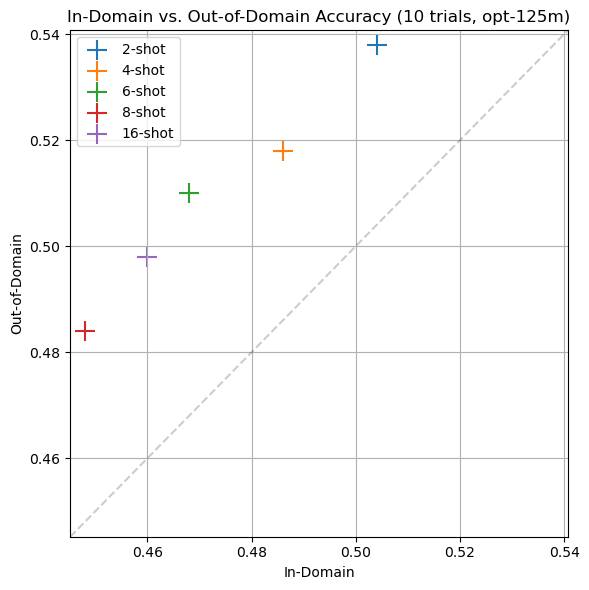

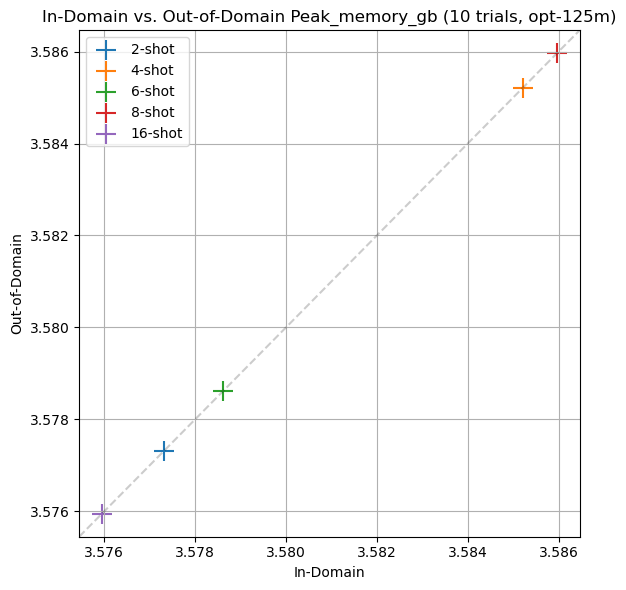

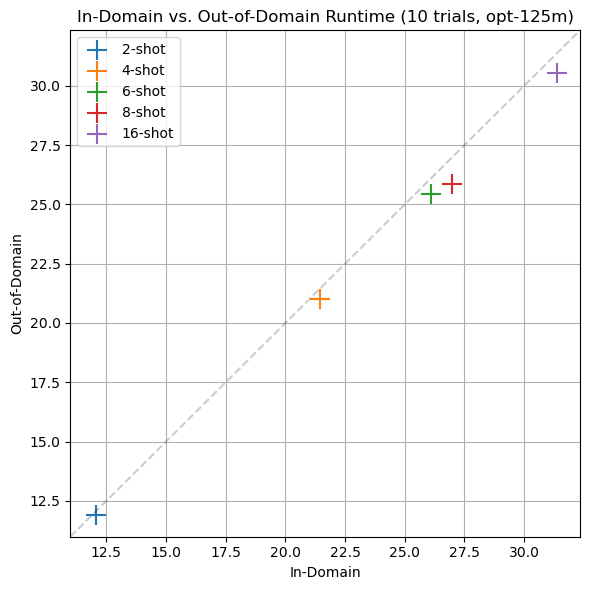

In [36]:
from src.visualization.plot import plot_in_out_domain

plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='accuracy')
plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='peak_memory_gb')
plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='runtime')

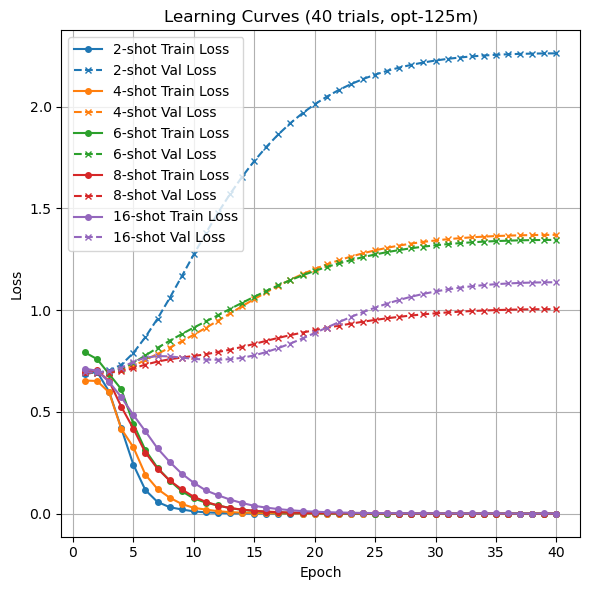

<Figure size 600x600 with 0 Axes>

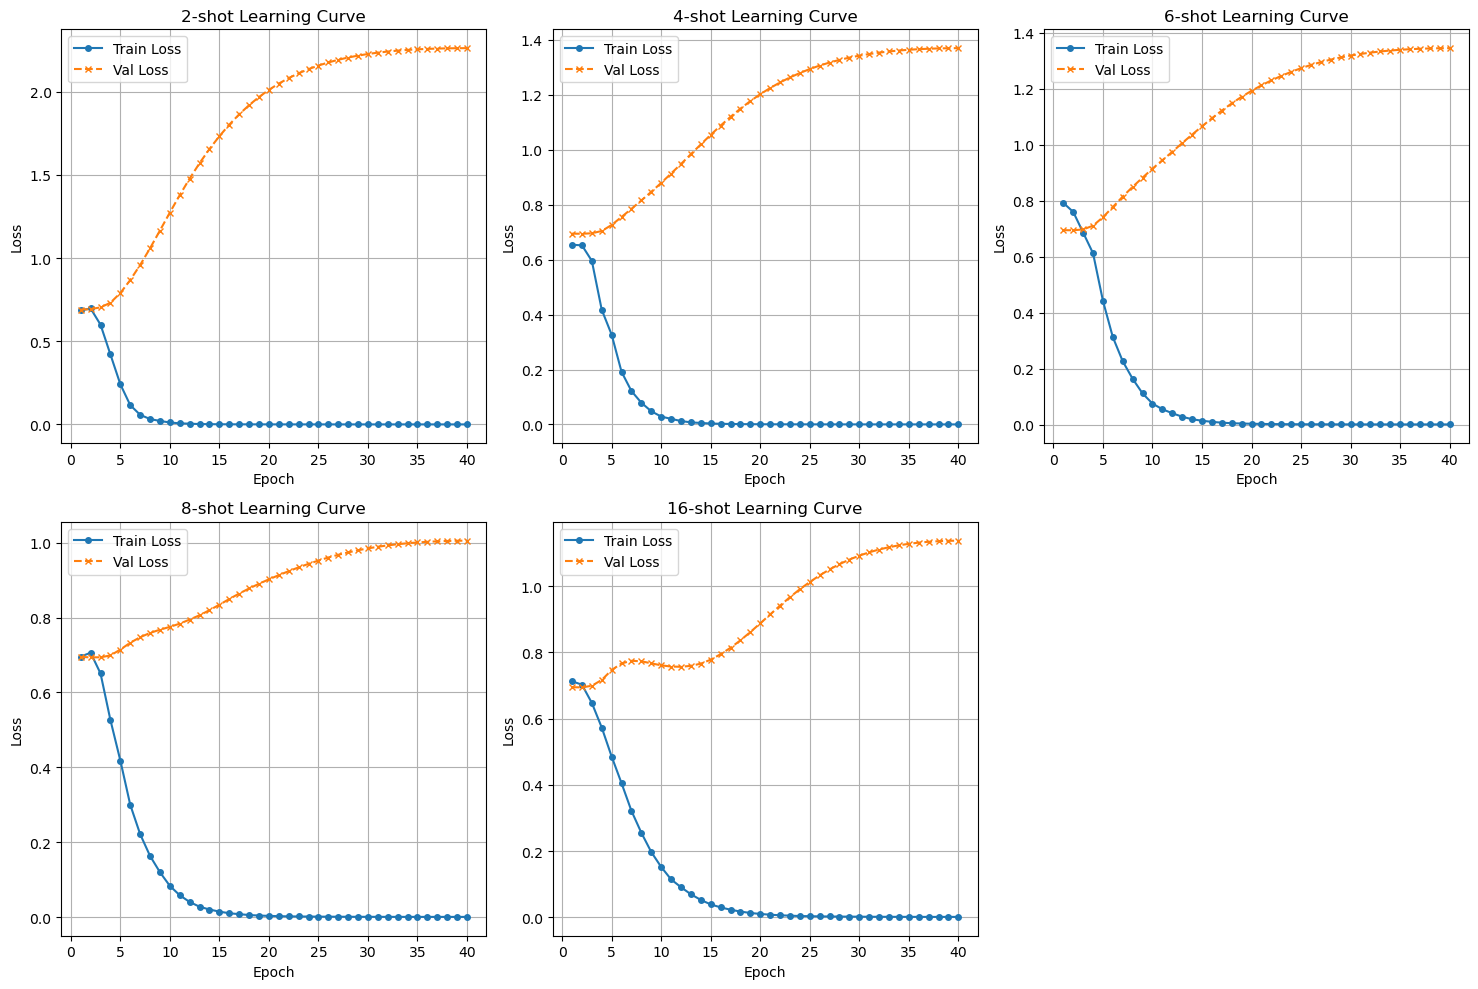

In [37]:
from src.visualization.plot import plot_learning_curves

plot_learning_curves(logfile='opt-125m_fewshot_training_history_2_4_6_8_16.csv', subplot=False)
plot_learning_curves(logfile='opt-125m_fewshot_training_history_2_4_6_8_16.csv', subplot=True)